In [ ]:
# QST5 -  Amazon Customer Review Analysis

In [1]:
## Executive Summary

## 1. Business Problem Definition

## 2. Data Sources

## 3. Data Cleaning (Kap & Evan)

### Before Cleaning

### After Cleaning

In [2]:
## 4. Exploratory
# To address the business questions, we plan to analyze the data and examine the correlations between various metrics. including how ratings relate to factors such as price, category, content, and type

In [3]:
# Import clean data
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("QuickPeakEDA").getOrCreate()
META_COMBINED_COMPACT = "gs://qst843-project/amazon_reviews_2023/silver/meta_combined_compact"
df_meta = spark.read.option("recursiveFileLookup", "true").parquet(META_COMBINED_COMPACT)
df_meta.show(5)

25/11/05 09:08:37 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+-----------+--------------------+-------------+----------+-----+--------------------+--------------------+--------------+-------------+-----+------------+-------------+-------------+-------------+
|parent_asin|               title|main_category|categories|price|            features|         description|average_rating|rating_number|brand|       store|product_image|product_video|category_name|
+-----------+--------------------+-------------+----------+-----+--------------------+--------------------+--------------+-------------+-----+------------+-------------+-------------+-------------+
| B01AB5SIXO|NuGene NuEye Eye ...|   All Beauty|        []| NULL|                  []|                  []|           5.0|            1| NULL|        NULL|         true|        false|   All_Beauty|
| B07DNP5SY9|18INCH #24 Ash Bl...|   All Beauty|        []| NULL|                  []|                  []|           1.0|            1| NULL|    benehair|         true|        false|   All_Beauty|
| B08F51HG

In [4]:
df_meta.limit(5).toPandas()


,parent_asin,title,main_category,categories,price,features,description,average_rating,rating_number,brand,store,product_image,product_video,category_name
0,B01AB5SIXO,NuGene NuEye Eye Serum - Innovative Cutting-Ed...,All Beauty,[],NaN,[],[],5.0,1,None,None,True,False,All_Beauty
1,B07DNP5SY9,18INCH #24 Ash Blonde TAPE in HUAMN HAIR EXTEN...,All Beauty,[],NaN,[],[],1.0,1,None,benehair,True,False,All_Beauty
2,B08F51HG1R,Headbands for Women Boho Headbands Vintage Flo...,All Beauty,[],NaN,[],[],4.3,23,None,makersland,True,True,All_Beauty
3,B00IIAJYEC,"""THE NASTY"" Masculine Pheromone Cologne with t...",All Beauty,[],NaN,"[""THE NASTY""PHEROMONE COMPLEX BLEND is one of ...",[Men around the world use SpellboundRX Masculi...,3.2,45,None,spellboundrx,True,False,All_Beauty
4,B07Q8XGVLG,Makeup Blur Removal Cloth 12 Pads Per Set - Ge...,All Beauty,[],NaN,[],[],4.4,24,None,makeup blur,True,False,All_Beauty


In [5]:
## 1. Chart1: Which product categories perform best when accounting for popularity and reliability?
#In the retail industry, evaluating performance across different product categories is crucial for identifying underlying issues and uncovering actionable insights. For example, if customer feedback or ratings in the Beauty category are relatively low, it may indicate the need to improve product quality or reconsider suppliers in that segment.

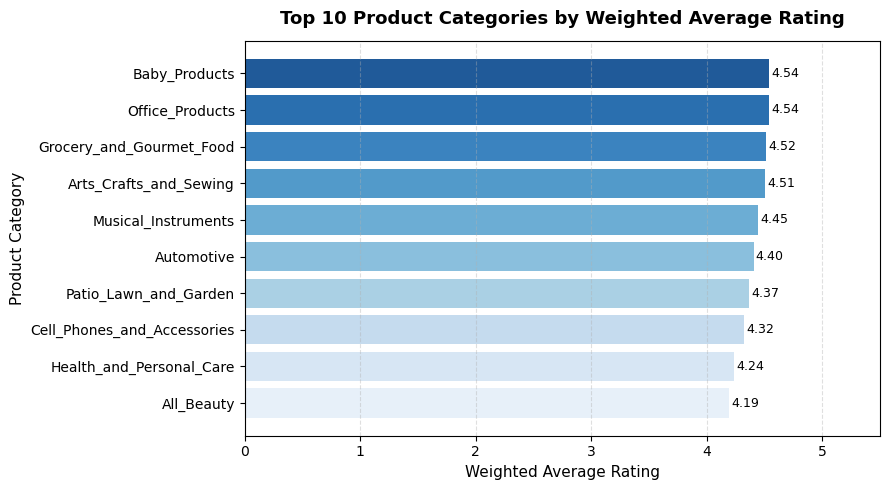

In [6]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Compute weighted average per category
#
weighted = (
    df_meta.filter(F.col("rating_number") > 0)
    .groupBy("category_name")
    .agg(
        (F.sum(F.col("average_rating") * F.col("rating_number")) / F.sum("rating_number")).alias("weighted_avg"),
        F.count("*").alias("n")
    )
    .orderBy(F.desc("weighted_avg"))
)

# Step 2: Convert to pandas (Top 10)
pdf_weighted = weighted.limit(10).toPandas()

# Step 3: Create gradient color palette based on rating value
colors = sns.color_palette("Blues", n_colors=len(pdf_weighted))
colors = colors[::-1]  # reverse so highest is darkest

# Step 4: Plot
plt.figure(figsize=(9,5))
bars = plt.barh(
    pdf_weighted["category_name"],
    pdf_weighted["weighted_avg"],
    color=colors,
    alpha=0.9
)

# Add numeric labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.02, bar.get_y() + bar.get_height()/2,
             f"{width:.2f}", va='center', fontsize=9, color='black')

# Labels, title, and styling
plt.xlabel("Weighted Average Rating", fontsize=11)
plt.ylabel("Product Category", fontsize=11)
plt.title("Top 10 Product Categories by Weighted Average Rating", fontsize=13, weight='bold', pad=12)

plt.xlim(0, 5.5)
plt.gca().invert_yaxis()  # highest at top
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [7]:
##Insights: From the chart, we can see that Baby Products, Office Products, and Grocery & Gourmet Food receive the highest ratings on the platform. However, more personal categories such as Beauty, Health & Personal Care, and Cell Phones tend to have lower ratings. This suggests that Amazon performs strongly in general, functional product categories with lower differentiation needs, but is less effective in categories that require personalization and must cater to diverse customer preferences

In [8]:
##2. Chart2: Which product categories show higher or lower customer satisfaction?
# Different from previous charts, we want to look into the rating distribution in different categories so we can improve the rating performance accrodigly.

/tmp/ipykernel_87356/3595162685.py:12: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_87356/3595162685.py:12: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


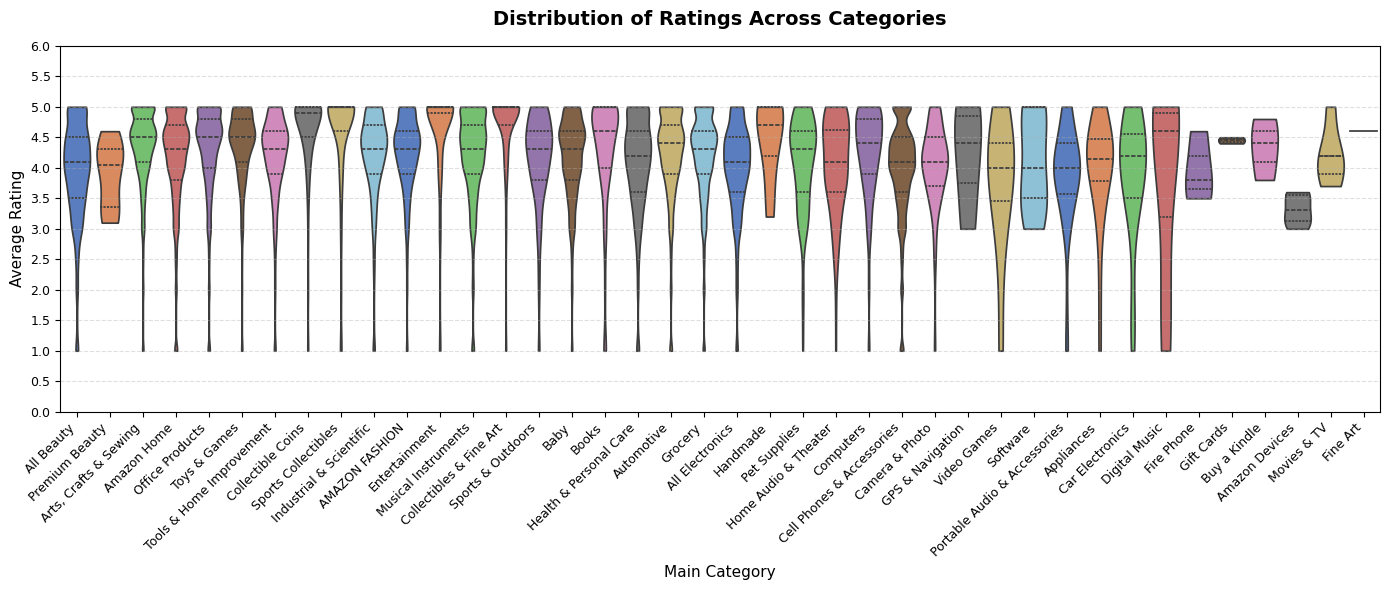

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sampling
pdf = df_meta.sample(0.02).toPandas()

# Setting figure
plt.figure(figsize=(14,6))

#  violin plot 
sns.violinplot(
    x="main_category",
    y="average_rating",
    data=pdf,
    inner="quart",     
    cut=0,             
    scale="width",     
    palette="muted"    
)


plt.xticks(rotation=45, ha="right", fontsize=9)


plt.yticks([i/2 for i in range(0,13)], fontsize=9)
plt.ylim(0,6)  
plt.title("Distribution of Ratings Across Categories", fontsize=14, weight='bold', pad=15)
plt.xlabel("Main Category", fontsize=11)
plt.ylabel("Average Rating", fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()



In [10]:
#Insights:The violin plot shows that most categories cluster around an average rating of 4.0–4.5, with relatively small variation. However, we can see that categories such as Fire Phone and GPS & Navigation have noticeably lower scores compared to others. In addition, Cell Phones, Cameras, and Portable Audio categories also show slightly lower average ratings (around 4.0), suggesting that these areas could be prioritized for improvement. Moreover, some categories, while maintaining a decent average rating, have relatively few five-star reviews indicating that most customer experiences fall around the four-star range rather than being highly satisfactory.

In [11]:
##Chart3: Does price influence customer ratings?
# We want to dig into the price metric and check if higher price do means better quality (this could dive into deeper analysis by different category but now we look into general conditions)

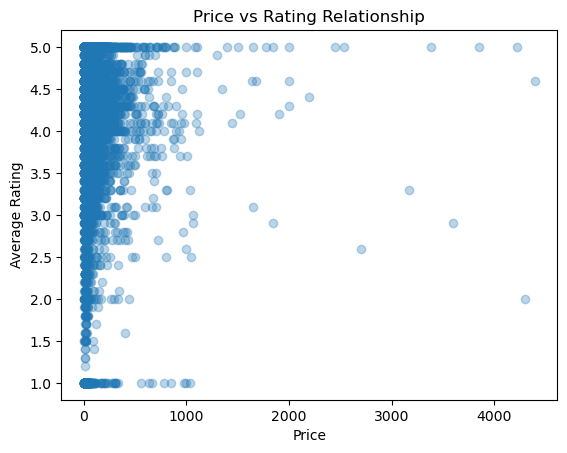

In [12]:
pdf = df_meta.filter(
    (F.col("price") > 0) & (F.col("price") < 5000) & (F.col("average_rating").isNotNull())
).sample(0.01).toPandas()

import matplotlib.pyplot as plt

plt.scatter(pdf["price"], pdf["average_rating"], alpha=0.3)
plt.xlabel("Price")
plt.ylabel("Average Rating")
plt.title("Price vs Rating Relationship")
plt.show()

In [13]:
#Insights: Most products, regardless of cost, cluster around 4–5 stars, while lower ratings occur across all price ranges.From the chart, there is no significant trand showing higer price must bring higher rating. But when price reach to $3250, there is less ratings under2.5.

In [14]:
## 4. Chart4: Does richer product content (images, videos, longer descriptions) improve ratings?
#This chart was created to examine how product content quality, such as images, videos, and description length affects customer ratings and overall satisfaction.

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# FacetGrid with shared y-axis (purple theme)
g = sns.FacetGrid(pdf_summary, col="content_type", col_wrap=2, height=3.2, sharey=True)
g.map_dataframe(
    sns.barplot,
    x="desc_group", y="avg_rating",
    palette=sns.color_palette("BuPu", n_colors=3),
    order=["Short","Medium","Long"]
)

# Unify y-axis scale
g.set(ylim=(3.8, 4.7))

# Add value labels on bars
for ax in g.axes.flatten():
    for c in ax.containers:
        ax.bar_label(c, fmt="%.2f", fontsize=8, padding=2)
    ax.set_xlabel("Description Length", fontsize=9)
    ax.set_ylabel("Average Rating", fontsize=9)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

# Titles and layout
g.set_titles(col_template="{col_name}", size=10, weight='bold')
plt.subplots_adjust(top=0.88)
g.fig.suptitle("Impact of Content Type and Description Length on Ratings", fontsize=13, weight='bold')
plt.show()



NameError: name 'pdf_summary' is not defined

In [ ]:
#Insights:Across all subplots, products that include videos or images consistently receive higher ratings than those without.Interestingly, products with shorter or medium-length descriptions also tend to perform slightly better than those with long ones — possibly because concise information improves readability and trust.This supports the hypothesis that visual and clear content presentation positively affects perceived product quality.

In [ ]:
## 5. Chart5: Which are the best performing stores according to the maximum number of products?
#We want to look into which stores have the maximum amount of products listed on Amazon and understand their importance. 

+---------------+----------+
|          store|n_products|
+---------------+----------+
|        generic|     39203|
|        unknown|     10577|
|          mybat|      8335|
| amazon renewed|      6751|
|graphics & more|      6281|
|        asuwish|      5679|
|        coveron|      5613|
|       otterbox|      5420|
|        samsung|      5394|
|         3drose|      5373|
+---------------+----------+
only showing top 10 rows



/tmp/ipykernel_87356/2333495818.py:18: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


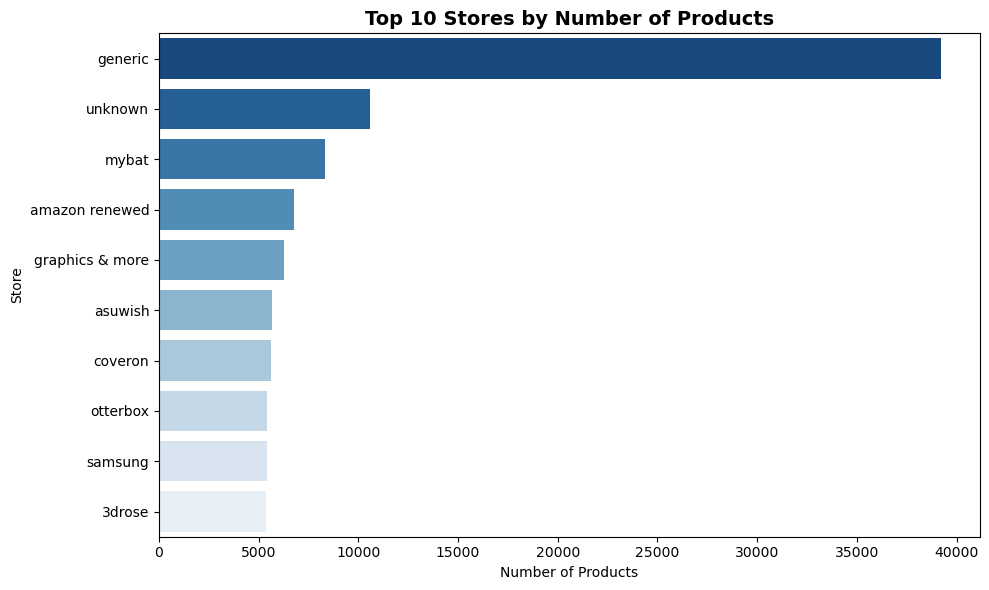

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
# Take top 10 stores
store_product_counts = (
    df_meta.filter(
        (F.col("store").isNotNull()) & 
        (F.col("store") != "") 
    )
    .groupBy("store")
    .agg(F.count("*").alias("n_products"))
    .orderBy(F.desc("n_products"))
)

store_product_counts.show(10)
store_counts_pdf = store_product_counts.limit(10).toPandas()

plt.figure(figsize=(10,6))
sns.barplot(
    x="n_products", 
    y="store", 
    data=store_counts_pdf, 
    palette="Blues_r"
)
plt.title("Top 10 Stores by Number of Products", fontsize=14, weight="bold")
plt.xlabel("Number of Products")
plt.ylabel("Store")
plt.tight_layout()
plt.show()


In [17]:
#Insights : We can see that the stores 'generic' and 'unknown' have really high number of products which makes it suspicious towards if they are stores or default options for unbranded items.

In [ ]:
##Chart 6. Lets check how the number of items and average rating varies across categories for each store

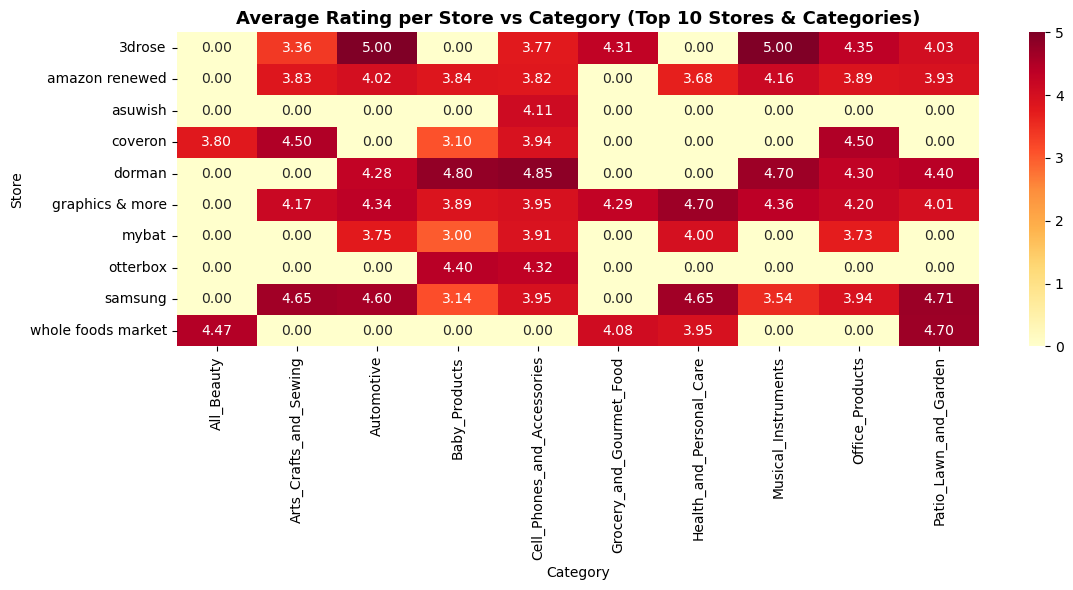

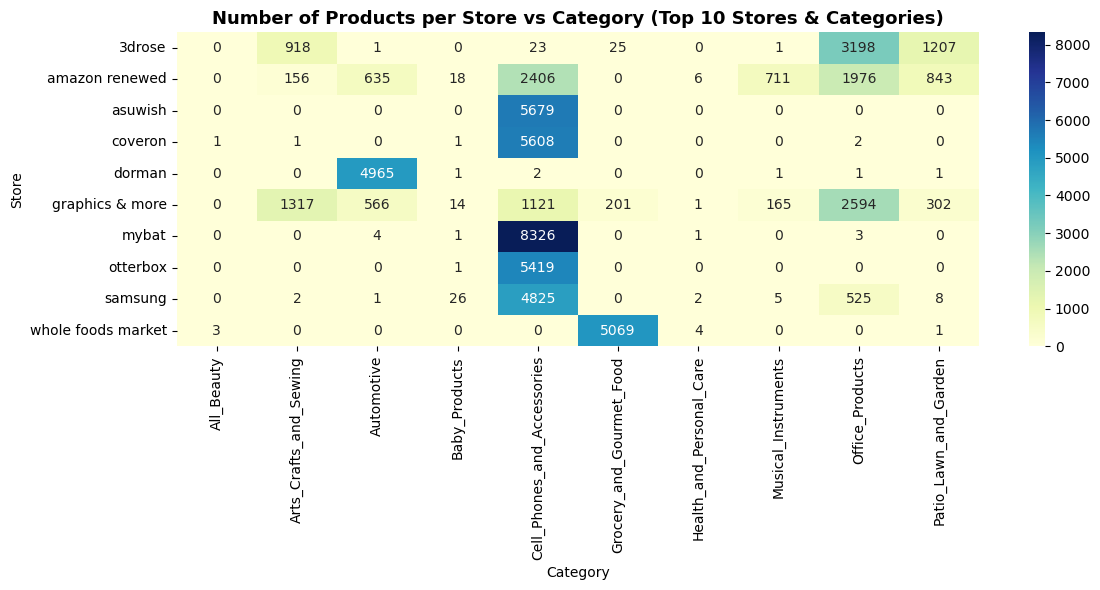

In [36]:
from pyspark.sql import functions as F

store_category_stats = (
    df_meta.filter(
        (F.col("store").isNotNull()) & (F.col("store") != "") & (F.col("store") != "generic") & (F.col("store") != "unknown") &
        (F.col("category_name").isNotNull()) & (F.col("category_name") != "") & (F.col("category_name") != "unknown") & (F.col("category_name") != "generic") &
        (F.col("average_rating").isNotNull())
    )
    .groupBy("store", "category_name")
    .agg(
        F.count("*").alias("n_products"),
        F.round(F.avg("average_rating"), 2).alias("avg_rating")
    )
    .orderBy(F.desc("n_products"))
)

store_category_pdf = store_category_stats.toPandas()

top_stores = store_category_pdf.groupby("store")["n_products"].sum().sort_values(ascending=False).head(10).index
top_categories = store_category_pdf.groupby("category_name")["n_products"].sum().sort_values(ascending=False).head(10).index

filtered_pdf = store_category_pdf[
    store_category_pdf["store"].isin(top_stores) &
    store_category_pdf["category_name"].isin(top_categories)
].copy()

heatmap_rating = filtered_pdf.pivot(index="store", columns="category_name", values="avg_rating").fillna(0)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.heatmap(heatmap_rating, annot=True, fmt=".2f", cmap="YlOrRd")
plt.title("Average Rating per Store vs Category (Top 10 Stores & Categories)", fontsize=13, weight="bold")
plt.xlabel("Category")
plt.ylabel("Store")
plt.tight_layout()
plt.show()

heatmap_products = filtered_pdf.pivot(index="store", columns="category_name", values="n_products").fillna(0)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.heatmap(heatmap_products, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Number of Products per Store vs Category (Top 10 Stores & Categories)", fontsize=13, weight="bold")
plt.xlabel("Category")
plt.ylabel("Store")
plt.tight_layout()
plt.show()


In [ ]:
##Q7. Are there any products which don't deserve to be expensive according to their reviews?
#We are trying to check for the products which have really low rating have justified prices

In [40]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from pyspark.sql import functions as F

output_notebook()

# 1️⃣ Select top 50 most expensive items with price, rating, and category
top_50_pdf = (
    df_meta.filter(
        (F.col("price").isNotNull()) & 
        (F.col("average_rating").isNotNull()) &
        (F.col("category_name").isNotNull())
    )
    .withColumn("price_float", F.col("price").cast("double"))
    .filter(F.col("price_float") > 0)
    .select("title", "price_float", "average_rating", "category_name")
    .orderBy(F.desc("price_float"))
    .limit(50)  # top 50
    .toPandas()
)

# 2️⃣ Convert to Bokeh ColumnDataSource
source = ColumnDataSource(top_50_pdf)

# 3️⃣ Create figure
p = figure(
    title="Top 50 Most Expensive Products vs Ratings",
    x_axis_label='Price ($)',
    y_axis_label='Average Rating',
    width=900,
    height=500,
    tools="pan,wheel_zoom,box_zoom,reset,hover,save"
)

# 4️⃣ Add scatter points
p.circle(
    x='price_float',
    y='average_rating',
    size=10,
    source=source,
    fill_color='navy',
    fill_alpha=0.6,
    line_color=None
)

# 5️⃣ Add hover tool including category
hover = p.select_one(HoverTool)
hover.tooltips = [
    ("Title", "@title"),
    ("Category", "@category_name"),
    ("Price", "@price_float{$0,0.00}"),
    ("Rating", "@average_rating")
]

# 6️⃣ Show plot
show(p)

# 7️⃣ Optional: Display table of top 50 products with category
print(top_50_pdf)


Loading BokehJS ...

                                                title  price_float  \
0   1884 S American Silver Morgan Dollar MS-67 Ill...   1099995.00   
1   Sports Memorabilia Cal Ripken Jr. 1981 Rookie ...    890908.99   
2   1895 O American Silver Morgan Dollar MS-66 Ill...    549995.00   
3   1886 O American Silver Morgan Dollar MS-65+ PQ...    539995.00   
4   1885 CC American Silver Morgan Dollar MS-68+ I...    515000.00   
5   Mickey Mantle Autographed Set Four M Enterpris...    363639.99   
6   1952 Topps 33 Warren Spahn (Black back) Braves...    354555.99   
7   1893 CC American Silver Morgan Dollar MS-65+ P...    244995.00   
8   1894 O American Silver Morgan Dollar MS-65+ Il...    224000.00   
9   2019-20 Panini Prizm #249 Ja Morant RC Rookie ...    181992.99   
10  Patrick Mahomes 2017 Panini Select RC Silver P...    163648.99   
11  2009-10 Stephen Curry Topps Gold RC Signed Aut...    162009.89   
12  1902 S American Silver Morgan Dollar MS-67 Ill...    117995.00   
13  Michael Jordan A

25/11/05 09:45:24 WARN BlockManagerMasterEndpoint: No more replicas available for broadcast_65_piece0 !
25/11/05 09:45:24 WARN BlockManagerMaster: Failed to remove broadcast 65 with removeFromMaster = true - org.apache.spark.SparkException: Could not find BlockManagerEndpoint1.
	at org.apache.spark.rpc.netty.Dispatcher.postMessage(Dispatcher.scala:178)
	at org.apache.spark.rpc.netty.Dispatcher.postRemoteMessage(Dispatcher.scala:136)
	at org.apache.spark.rpc.netty.NettyRpcHandler.receive(NettyRpcEnv.scala:683)
	at org.apache.spark.network.server.TransportRequestHandler.processRpcRequest(TransportRequestHandler.java:163)
	at org.apache.spark.network.server.TransportRequestHandler.handle(TransportRequestHandler.java:109)
	at org.apache.spark.network.server.TransportChannelHandler.channelRead0(TransportChannelHandler.java:140)
	at org.apache.spark.network.server.TransportChannelHandler.channelRead0(TransportChannelHandler.java:53)
	at io.netty.channel.SimpleChannelInboundHandler.channelRea

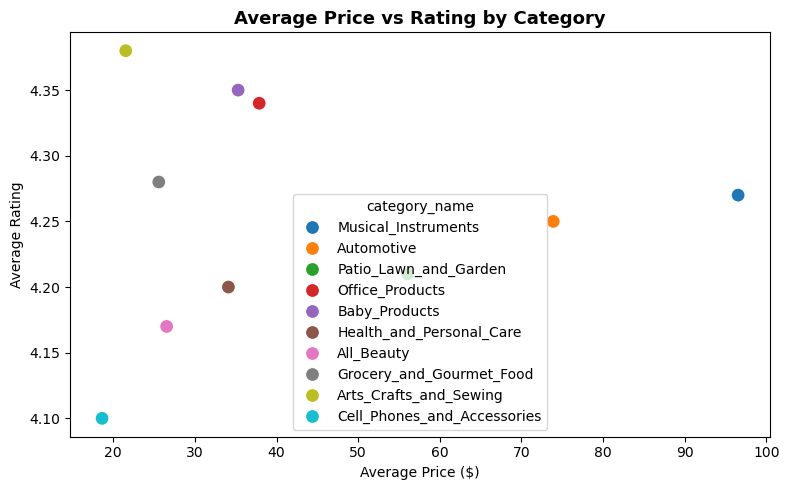

In [24]:
price_rating_cat = (
    df_meta.filter(
        (F.col("price") > 0) & 
        (F.col("price") < 1000) & 
        (F.col("average_rating") > 0)
    )
    .groupBy("category_name")
    .agg(
        F.round(F.avg("price"), 2).alias("avg_price"),
        F.round(F.avg("average_rating"), 2).alias("avg_rating")
    )
    .orderBy(F.desc("avg_price"))
    .limit(15)
    .toPandas()
)

plt.figure(figsize=(8,5))
sns.scatterplot(
    data=price_rating_cat,
    x="avg_price", y="avg_rating",
    hue="category_name", s=100
)
plt.title("Average Price vs Rating by Category", fontsize=13, weight="bold")
plt.xlabel("Average Price ($)")
plt.ylabel("Average Rating")
plt.tight_layout()
plt.show()


In [1]:
# Spark init. / Data Path
from pyspark.sql import SparkSession
bucket = spark._jsc.hadoopConfiguration().get("fs.gs.system.bucket")
review_path = "gs://" + bucket + "/amazon_reviews_2023/silver/reviews_combined_compact"
meta_path = "gs://" + bucket + "/amazon_reviews_2023/silver/meta_combined_compact"
print(review_path)
print(meta_path)

gs://qst843-project/amazon_reviews_2023/silver/reviews_combined_compact
gs://qst843-project/amazon_reviews_2023/silver/meta_combined_compact


In [2]:
# Load Cleaned Data (Review & Meta)
df_review = spark.read.option("recursiveFileLookup", "true").parquet(review_path)
df_meta = spark.read.option("recursiveFileLookup", "true").parquet(meta_path)

In [3]:
# Rename / Drop Duplicate Field Names ("title", "category_name")
df_review = df_review.withColumnRenamed("title", "review_title")
df_meta = df_meta.withColumnRenamed("title", "product_name")
df_meta = df_meta.drop("category_name")

In [4]:
# Check Review Data
df_review.printSchema()
df_review.show()

root
 |-- user_id: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- rating: integer (nullable = true)
 |-- review_title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- helpful_vote: integer (nullable = true)
 |-- verified_purchase: boolean (nullable = true)
 |-- review_image: boolean (nullable = true)
 |-- category_name: string (nullable = true)



+--------------------+-----------+-------------------+------+--------------------+--------------------+------------+-----------------+------------+--------------------+
|             user_id|parent_asin|          timestamp|rating|        review_title|                text|helpful_vote|verified_purchase|review_image|       category_name|
+--------------------+-----------+-------------------+------+--------------------+--------------------+------------+-----------------+------------+--------------------+
|AGZPNP4EC4Z7CTHY2...| B07V34XSJ8|2021-05-30 08:51:53|     5|        Comfortable!|    These are great!|           0|             true|       false|Arts_Crafts_and_S...|
|AFOCCQXZYCTLGLQ4Y...| B0047BITNI|2015-03-10 18:23:14|     5|          Five Stars|          very nice.|           0|             true|       false|Arts_Crafts_and_S...|
|AE5XOXRPK5ZCDD2DC...| B08Z7CRNSC|2022-01-17 16:45:32|     5|        Very pleased|  Just what I wanted|           0|             true|       false|Arts_Cra

In [5]:
# Check Meta Data
df_meta.printSchema()
df_meta.show()

root
 |-- parent_asin: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- price: double (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- average_rating: double (nullable = true)
 |-- rating_number: long (nullable = true)
 |-- brand: string (nullable = true)
 |-- store: string (nullable = true)
 |-- product_image: boolean (nullable = true)
 |-- product_video: boolean (nullable = true)



+-----------+--------------------+-------------+----------+-----+--------------------+--------------------+--------------+-------------+-----+-------------+-------------+-------------+
|parent_asin|        product_name|main_category|categories|price|            features|         description|average_rating|rating_number|brand|        store|product_image|product_video|
+-----------+--------------------+-------------+----------+-----+--------------------+--------------------+--------------+-------------+-----+-------------+-------------+-------------+
| B01AB5SIXO|NuGene NuEye Eye ...|   All Beauty|        []| NULL|                  []|                  []|           5.0|            1| NULL|         NULL|         true|        false|
| B07DNP5SY9|18INCH #24 Ash Bl...|   All Beauty|        []| NULL|                  []|                  []|           1.0|            1| NULL|     benehair|         true|        false|
| B08F51HG1R|Headbands for Wom...|   All Beauty|        []| NULL|          

In [7]:
# Join Review & Meta Data into a Single df
df = df_review.join(
    df_meta,
    on="parent_asin",
    how="left"
)

In [8]:
# Check Joined Data
df.printSchema()
df.show()

root
 |-- parent_asin: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- rating: integer (nullable = true)
 |-- review_title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- helpful_vote: integer (nullable = true)
 |-- verified_purchase: boolean (nullable = true)
 |-- review_image: boolean (nullable = true)
 |-- category_name: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- price: double (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- average_rating: double (nullable = true)
 |-- rating_number: long (nullable = true)
 |-- brand: string (nullable = true)
 |-- store: string (nullable = true)
 |-- produ

+-----------+--------------------+-------------------+------+--------------------+--------------------+------------+-----------------+------------+--------------------+--------------------+--------------------+--------------------+------+--------------------+--------------------+--------------+-------------+-----+--------------+-------------+-------------+
|parent_asin|             user_id|          timestamp|rating|        review_title|                text|helpful_vote|verified_purchase|review_image|       category_name|        product_name|       main_category|          categories| price|            features|         description|average_rating|rating_number|brand|         store|product_image|product_video|
+-----------+--------------------+-------------------+------+--------------------+--------------------+------------+-----------------+------------+--------------------+--------------------+--------------------+--------------------+------+--------------------+--------------------+--

In [9]:
df.select("category_name").distinct().show(truncate=False)

+---------------------------+
|category_name              |
+---------------------------+
|Patio_Lawn_and_Garden      |
|Cell_Phones_and_Accessories|
|Automotive                 |
|Arts_Crafts_and_Sewing     |
|Grocery_and_Gourmet_Food   |
|Baby_Products              |
|Office_Products            |
|Musical_Instruments        |
|Health_and_Personal_Care   |
|All_Beauty                 |
+---------------------------+



## EDA Part

### EDA 1.
#### Does verified purchase affect ratings?
According to the Amazon website (https://www.amazon.com/gp/help/customer/display.html?nodeId=G8UYX7LALQC8V9KA), \
**Verified Purchase** means that Amazon has confirmed the reviewer actually bought or used the product through their own Amazon account, or that the reviewer has an Amazon Credit Card associated with their account.

From this EDA section, we tried to find the correlation between *Verified Purchase* and *Review Rating*.
If *Verified Purchase* and *Review Rating* are **positively correlated**, we could develop strategies to increase the number of *Verified Purchases*.

In [10]:
from pyspark.sql import functions as F

# Boolean to Numeric (True=1, False=0)
df_corr = df.withColumn("verified_purchase", F.when(F.col("verified_purchase") == True, 1).otherwise(0))

# Compute Correlation Group by "category_name"
category_corr = (
    df_corr.groupBy("category_name")
    .agg(F.corr("verified_purchase", "rating").alias("correlation"))
    .orderBy(F.desc("correlation"))
)

category_corr.show(20, truncate=False)


+---------------------------+----------------------+
|category_name              |correlation           |
+---------------------------+----------------------+
|Baby_Products              |0.04945546563377559   |
|Grocery_and_Gourmet_Food   |0.04055285348296323   |
|Musical_Instruments        |0.03743306353613122   |
|Automotive                 |0.037106652631418185  |
|Office_Products            |0.03660729525966332   |
|Patio_Lawn_and_Garden      |0.02693815580948025   |
|Cell_Phones_and_Accessories|0.00910146141331315   |
|Arts_Crafts_and_Sewing     |0.008831825752796058  |
|Health_and_Personal_Care   |-0.0025580924708461738|
|All_Beauty                 |-0.02476111260203552  |
+---------------------------+----------------------+



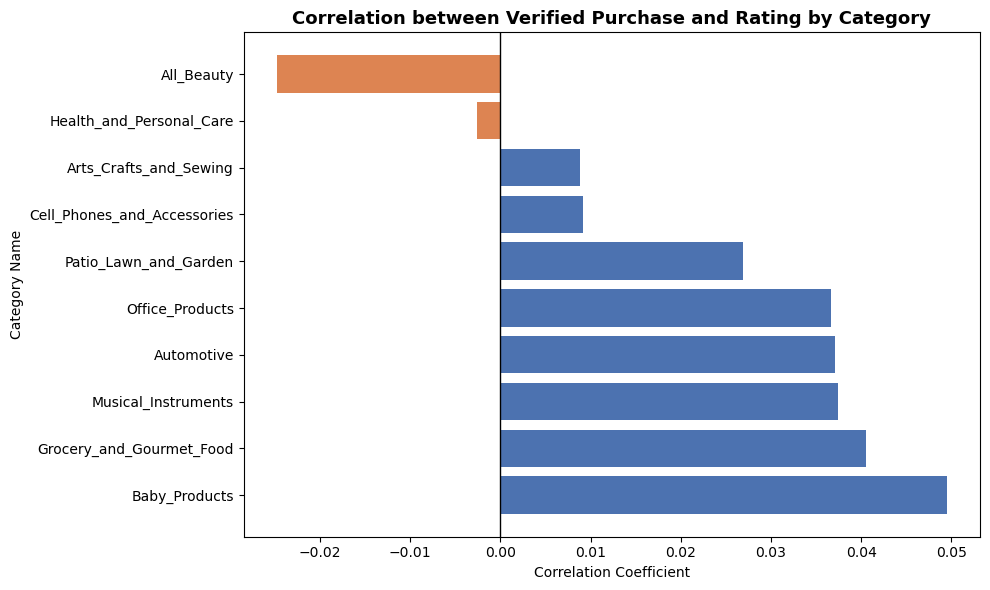

In [13]:
import matplotlib.pyplot as plt

# Visualize Correlations with Bar Graph
pdf_corr = category_corr.toPandas().dropna(subset=["correlation"])

plt.figure(figsize=(10, 6))
plt.barh(
    pdf_corr["category_name"],
    pdf_corr["correlation"],
    color=["#4C72B0" if c > 0 else "#DD8452" for c in pdf_corr["correlation"]]
)
plt.axvline(0, color="black", lw=1)
plt.title("Correlation between Verified Purchase and Rating by Category", fontsize=13, weight='bold')
plt.xlabel("Correlation Coefficient")
plt.ylabel("Category Name")
plt.tight_layout()
plt.show()


#### Insight)
We found that the correlation between *Verified Purchase* and *Review Rating* is **very weak**, \
but we found slight of correlation difference between "All_Beauty" and "Baby_Products" (Negative / Positive)

#### Verified Purchases Skewness
We found that there is very weak correlation between *Verified Purchase* and *Review Rating*. \
Although some categories showed differences in negative and positive correlations, we aimed to take a closer look at each category’s characteristics by examining how *Verified Purchase* and *Non-Verified Purchase* reviews are actually skewed.

By comparing *Verified Purchase* and *Non-Verified Purchase* reviews, we aim to identify which product categories show the highest and most significant skewness toward high ratings among verified purchases. \
For those categories, it would likely be advantageous to implement targeted strategies focused on increasing the proportion of Verified Purchases.

In [28]:
from pyspark.sql import functions as F
# Calculate skewness of ratings
def skew_by_category(df_in):
    base = (df_in
            .filter(F.col("rating").between(1, 5))
            .filter(F.col("category_name").isNotNull())
            .select("category_name", F.col("rating").cast("double").alias("x")))
    
    mom = (base.groupBy("category_name")
           .agg(F.count("x").alias("n"),
                F.sum("x").alias("s1"),
                F.sum(F.pow("x", 2)).alias("s2"),
                F.sum(F.pow("x", 3)).alias("s3")))
    
    res = (mom
        .withColumn("mu", F.col("s1")/F.col("n"))
        .withColumn("m2", (F.col("s2")/F.col("n")) - F.col("mu")**2)
        .withColumn("m3", (F.col("s3")/F.col("n")) - 3*F.col("mu")*(F.col("s2")/F.col("n")) + 2*F.col("mu")**3)
        .withColumn("g1", (F.sqrt(F.col("n")*(F.col("n")-1))/(F.col("n")-2)) * (F.col("m3")/F.col("m2")**1.5))
        .select(
            "category_name",
            F.col("n").alias("cnt"),
            F.col("mu").alias("mean_rating"),
            F.when((F.col("n") > 2) & (F.col("m2") > 0), -1*F.col("g1")).alias("skew")  # + = 4~5 쏠림
        ))
    return res

# Differentiate Verified vs. non-Verified
ver  = skew_by_category(df.filter(F.col("verified_purchase") == True)).alias("v")
non  = skew_by_category(df.filter(F.col("verified_purchase") == False)).alias("nv")

# Join verified and non-verified calculations
skew_compare = (ver.join(non, "category_name", "inner")
    .select(
        F.col("category_name"),
        F.col("v.cnt").alias("cnt_verified"),
        F.col("nv.cnt").alias("cnt_nonverified"),
        F.col("v.mean_rating").alias("mean_verified"),
        F.col("nv.mean_rating").alias("mean_nonverified"),
        F.col("v.skew").alias("skew_verified"),
        F.col("nv.skew").alias("skew_nonverified"),
    ))

skew_compare.show(20, truncate=False)

# Pandas for graph
pdf = skew_compare.toPandas()



+---------------------------+------------+---------------+------------------+------------------+------------------+------------------+
|category_name              |cnt_verified|cnt_nonverified|mean_verified     |mean_nonverified  |skew_verified     |skew_nonverified  |
+---------------------------+------------+---------------+------------------+------------------+------------------+------------------+
|All_Beauty                 |628456      |65796          |3.948922438484158 |4.0752173384400265|1.0690200099387248|1.2988042047572939|
|Patio_Lawn_and_Garden      |15362546    |955592         |4.059853230057049 |3.8915363460556387|1.251022897660583 |1.0193568513041915|
|Cell_Phones_and_Accessories|19501687    |1074696        |4.019075529209345 |3.9592610375399184|1.1791391444118455|1.104413832854662 |
|Automotive                 |18984235    |738978         |4.1939568278626975|3.9241790689303335|1.4980238556345273|1.0624002928018461|
|Musical_Instruments        |2749398     |234382       

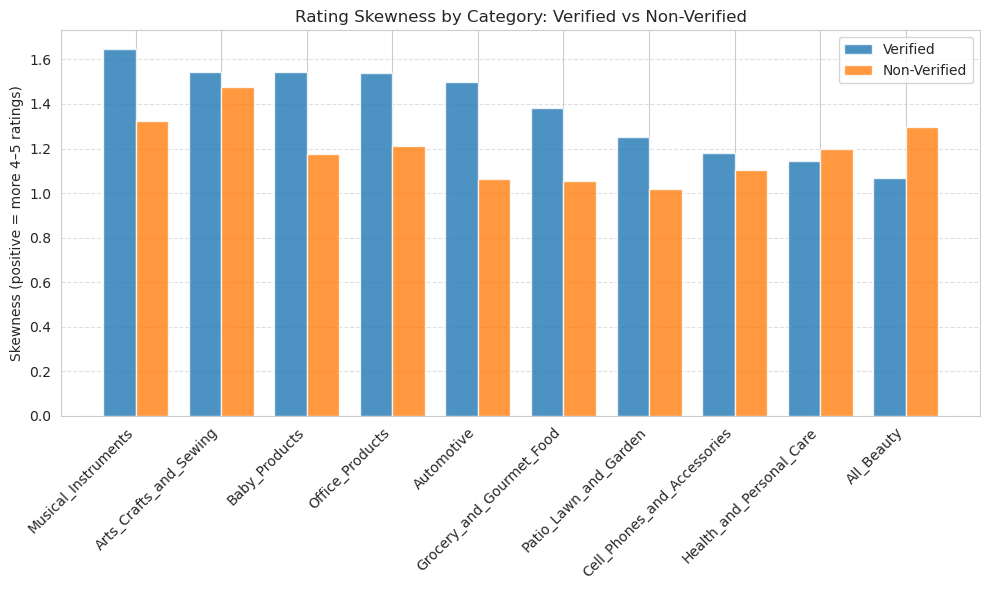

In [29]:
import matplotlib.pyplot as plt
import numpy as np
# Compare (non)Verified purchase skewness
pdf = skew_compare.toPandas().sort_values("skew_verified", ascending=False).head(10)

x = np.arange(len(pdf))
w = 0.38
plt.figure(figsize=(10,6))
plt.bar(x - w/2, pdf["skew_verified"],  width=w, label="Verified",     alpha=0.8)
plt.bar(x + w/2, pdf["skew_nonverified"], width=w, label="Non-Verified", alpha=0.8)
plt.xticks(x, pdf["category_name"], rotation=45, ha="right")
plt.ylabel("Skewness (positive = more 4–5 ratings)")
plt.title("Rating Skewness by Category: Verified vs Non-Verified")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()



#### Insight)
According to the EDA results, **Musical Instruments, Baby Products, Office Products, Automotive, and Grocery** categories showed noticeably higher skewness toward high ratings in *Verified Purchase* reviews compared to *Non-Verified Purchase* reviews. \
On the other hand, **All Beauty** products showed relatively lower skewness for *Verified Purchases*. \
Therefore, it is expected that implementing strategies to increase and encourage *Verified Purchases* in categories such as **Musical Instruments, Baby Products, Office Products, Automotive, and Grocery** would be advantageous.

### EDA 2
#### Helpful Votes and ratings
All Amazon users can vote on whether a review was helpful.\
This *helpful (review) vote* serves as an important indicator of how much people are influenced by, or empathize with, reviews that either compliment or criticize a product.\

We aim to examine whether these helpful votes are related with the overall product ratings.\
If we find that products receiving many helpful votes on critical (low-rated) reviews tend to have lower average ratings, it would strongly suggest potential issues with product or service quality that such products may require closer monitoring or review.\
Conversely, if our hypothesis turns out to be wrong and products with many helpful votes on critical reviews do not show any lower average ratings, it may imply that helpful votes have limited influence on perceived product quality or customer satisfaction.

In [18]:
from pyspark.sql import functions as F

# Sum / Calculate helpful votes when Rating=1, Rating=5
df_helpful = (
    df.groupBy("parent_asin")
      .agg(
          F.avg("rating").alias("avg_rating"),
          F.sum(F.when(F.col("rating") == 1, F.col("helpful_vote")).otherwise(0)).alias("helpful_sum_r1"),
          F.sum(F.when(F.col("rating") == 5, F.col("helpful_vote")).otherwise(0)).alias("helpful_sum_r5")
      )
      .withColumn("helpful_diff", F.col("helpful_sum_r5") - F.col("helpful_sum_r1"))
)



In [19]:
pdf_helpful = df_helpful.toPandas()

# Negative helpful_diff → skew to low ratings, Positive helpful_diff → skew to high ratings
pdf_helpful["trend_group"] = pd.cut(
    pdf_helpful["helpful_diff"],
    bins=[-float("inf"), -1, 0, 1, float("inf")],
    labels=["More votes on rating=1", "Balanced (~0)", "Slightly more on 5", "Strongly more on rating=5"]
)


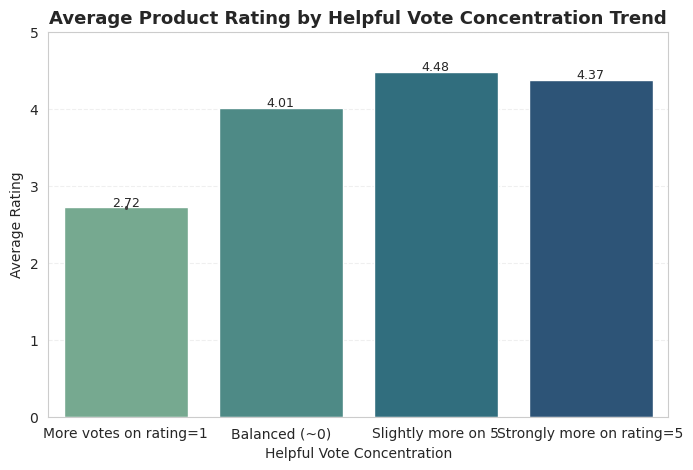

In [20]:
import seaborn as sns
# Show on Bar Graph
plt.figure(figsize=(8,5))
sns.barplot(
    data=pdf_helpful,
    x="trend_group",
    y="avg_rating",
    palette="crest",
    order=["More votes on rating=1", "Balanced (~0)", "Slightly more on 5", "Strongly more on rating=5"]
)

for i, v in enumerate(pdf_helpful.groupby("trend_group")["avg_rating"].mean()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=9)

plt.title("Average Product Rating by Helpful Vote Concentration", fontsize=13, weight='bold')
plt.xlabel("Helpful Vote Concentration")
plt.ylabel("Average Rating")
plt.ylim(0, 5)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()


#### Insight)
According to the graph, we observed a clear decline in the average rating as the number of helpful votes on critical (1-star) reviews increased.\
This finding supports our hypothesis: when critical reviews accumulate a large number of helpful votes, it can be considered as a red flag indicating potential issues with the product’s quality or service, warranting further investigation and corrective action.